# 集成学习

就是把几个不同的判别器集成为一个元判别器，可以得到一个更好的表现，更加准确，鲁棒性也更好


## 集成方法1： Majority voting
就是选择主要的判别器来作判别，过半数选票的判别器

## 集成方法2 ：Plurality voting
我们只选择最多选票的方法


这里是做了一个集成学习的，错误率计算公式，在错误率小于0.5的时候，采用集成学习，错误率会低很多

$P(y \geq k) = \sum_{k}^{n} \big\langle ^n_k \big\rangle \varepsilon^k (1-\varepsilon)^{n-k} = \varepsilon _{ensemble}$

In [2]:
from scipy.special import comb
import math


def ensemble_error(n_classifier, error):
    k_start = math.ceil(n_classifier / 2.0)
    probs = [comb(n_classifier, k) * error**k * (1-error)**(n_classifier - k) 
             for k in range(k_start, n_classifier + 1)]
    
    return sum(probs)


ensemble_error(n_classifier=11,error=0.25)
    

0.03432750701904297

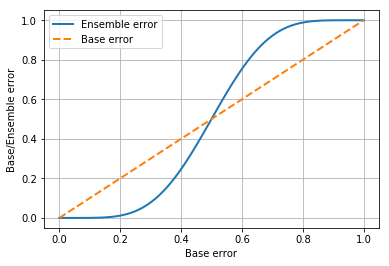

In [5]:
import numpy as np

error_range = np.arange(0.0,1.01,0.01)

ens_errors = [ensemble_error(n_classifier=11,error=error) 
               for error in error_range]

import matplotlib.pyplot as plt

plt.plot(error_range, ens_errors, label='Ensemble error', linewidth=2)

plt.plot(error_range, error_range, linestyle='--', label='Base error', linewidth=2)

plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')

plt.legend(loc='upper left')

plt.grid()
plt.show()

这里解释以下bincount和argmax两个函数

#### bincount

bincount就是找队列里面，每一个非负整数出现的次数，然后组成一个队列，从0到最大的整数，每一个单元就是对应那个整数出现的次数

```
np.bincount(np.array([1,3,6,1,2,3]))
```

结果是array([0, 2, 1, 2, 0, 0, 1])，第一个0就是‘0’出现了0次，第二个2就是‘1’出现了2次，第三个1就是‘2’出现了1次，如此类推

#### argmax

argmax就是从队列中找最大那个数的位置
例如：
```
a = np.array([[10, 11, 12],
       [13, 14, 15]])

np.argmax(a)  # 5 

np.argmax(a,axis=0) # [1,1,1]
```



In [19]:
print(np.bincount(np.array([1,3,6,1,2,3])))

print(np.bincount([0,0,1],weights=[0.2,0.2,0.6]))

[0 2 1 2 0 0 1]
[0.4 0.6]


In [13]:
a = np.array([[10, 11, 12],
       [13, 14, 15]])

print(np.argmax(a))  # 5 

print(np.argmax(a,axis=0)) # [1,1,1]

print(np.argmax(a,axis=1))

5
[1 1 1]
[2 2]


In [17]:
import numpy as np

np.argmax(np.bincount([0,0,1],weights=[0.2,0.2,0.6]))

1

In [21]:
ex = np.array([[0.9,0.1],
               [0.8,0.2],
               [0.4,0.6]])

p = np.average(ex,axis=0,weights=[0.2,0.2,0.6])

p

array([0.58, 0.42])

In [22]:
np.argmax(p)

0

In [24]:
(0.9 * 0.2 + 0.8* 0.2 + 0.4*0.6) 

0.5800000000000001

In [32]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


class MajorityVoteClassifier(BaseEstimator,
                             ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'}
      Default: 'classlabel'
      If 'classlabel' the prediction is based on
      the argmax of class labels. Else if
      'probability', the argmax of the sum of
      probabilities is used to predict the class label
      (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers]
      Optional, default: None
      If a list of `int` or `float` values are
      provided, the classifiers are weighted by
      importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers,
                 vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for
                                  key, value in
                                  _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix},
            shape = [n_samples, n_features]
            Matrix of training samples.

        y : array-like, shape = [n_samples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        # Use LabelEncoder to ensure class labels start
        # with 0, which is important for np.argmax
        # call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X,
                              self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    

    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix},
            Shape = [n_samples, n_features]
            Matrix of training samples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_samples]
            Predicted class labels.

        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X),
                                 axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in
                                      self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                           lambda x:
                           np.argmax(np.bincount(x,                                             
                                        weights=self.weights)),
                           axis=1,
                           arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix},
            shape = [n_samples, n_features]
            Training vectors, where n_samples is
            the number of samples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like,
            shape = [n_samples, n_classes]
            Weighted average probability for
            each class per sample.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, 
                               axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier,
                         self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(
                        step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out


In [33]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

iris = datasets.load_iris()

X,y = iris.data[50:,[1,2]],iris.target[50:]

le = LabelEncoder()

y = le.fit_transform(y)

In [34]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [36]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.5, random_state=1)